In [1]:
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Load the data
data_dir = Path('~/generated_outputs').expanduser()
# grab each subdirectory
subdirs = [x for x in data_dir.iterdir() if x.is_dir()]
subdirs

[PosixPath('/lfs/skampere1/0/kaif/generated_outputs/metrics'),
 PosixPath('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_number_theory'),
 PosixPath('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_intermediate_algebra'),
 PosixPath('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_algebra'),
 PosixPath('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_geometry'),
 PosixPath('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_precalculus'),
 PosixPath('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_counting_and_probability'),
 PosixPath('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_prealgebra')]

In [3]:
# extract dataset name from subdir
def format_dataset_name(name):
    return name.replace('/', '_').replace('EleutherAI_hendrycks_math', 'Hendrycks').replace('_', ' ').title()


dataset_names = [format_dataset_name(x.name) for x in subdirs]
dataset_names

['Metrics',
 'Hendrycks Number Theory',
 'Hendrycks Intermediate Algebra',
 'Hendrycks Algebra',
 'Hendrycks Geometry',
 'Hendrycks Precalculus',
 'Hendrycks Counting And Probability',
 'Hendrycks Prealgebra']

In [29]:
%%capture
from dataset import from_name
from prompt import generate_nshot_prompts
from dataset import load_datasets, BOXED_ANSWERS_DATASETS

import numpy as np
import json
# load the name maps
with open('name_maps.json', 'r') as f:
    name_maps = json.load(f)
    DATASET_MAP = name_maps['DATASET_MAP']
    MODEL_MAP = name_maps['MODEL_MAP']

datasets_raw = load_datasets(BOXED_ANSWERS_DATASETS)
datasets = {
    DATASET_MAP[dataset['name']]: dataset['data']['train']
    for dataset in datasets_raw
}

np.random.seed(0)
num_samples = 100
datasets_subset = {k: np.random.choice(v, num_samples, replace=False) for k, v in datasets.items()}

datasets = {k: list(v) for k, v in datasets.items()}

# prepend datasets_subset with 3 examples from datasets
datasets_subset = {k: datasets[k][:3] + list(v) for k, v in datasets_subset.items()}

datas = {k: generate_nshot_prompts(v, n=3) for k, v in datasets_subset.items()}

In [36]:
datas['Algebra'][0]['question']

'Answer the following 4 questions:\n\n1. Let \\[f(x) = \\left\\{\n\\begin{array}{cl} ax+3, &\\text{ if }x>2, \\\\\nx-5 &\\text{ if } -2 \\le x \\le 2, \\\\\n2x-b &\\text{ if } x <-2.\n\\end{array}\n\\right.\\]Find $a+b$ if the piecewise function is continuous (which means that its graph can be drawn without lifting your pencil from the paper).\n\nFor the piecewise function to be continuous, the cases must "meet" at $2$ and $-2$. For example, $ax+3$ and $x-5$ must be equal when $x=2$. This implies $a(2)+3=2-5$, which we solve to get $2a=-6 \\Rightarrow a=-3$. Similarly, $x-5$ and $2x-b$ must be equal when $x=-2$. Substituting, we get $-2-5=2(-2)-b$, which implies $b=3$. So $a+b=-3+3=\\boxed{0}$.\n\n\n2. A rectangular band formation is a formation with $m$ band members in each of $r$ rows, where $m$ and $r$ are integers. A particular band has less than 100 band members. The director arranges them in a rectangular formation and finds that he has two members left over. If he increases the 

In [31]:
with open('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_algebra/deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl', 'rb') as f:
    predictions, solutions = pickle.load(f)

In [5]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import torch
torch.set_float32_matmul_precision('medium')

from comet import download_model, load_from_checkpoint

# model_path = download_model("Unbabel/XCOMET-XL")
model_path = download_model("Unbabel/wmt23-cometkiwi-da-xl")
model = load_from_checkpoint(model_path)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

checkpoints/model.ckpt:   0%|          | 0.00/13.9G [00:00<?, ?B/s]

Encoder model frozen.


In [6]:
# data = [
#     # {
#     #     "src": datas['Hendrycks Algebra'][0]['question'],
#     #     "mt": predictions[0].outputs[0].text,
#     #     "ref": datas['Hendrycks Algebra'][0]['answer']
#     # }
#     {
#         "src": d['question'],
#         "mt": o.outputs[0].text,
#         "ref": d['answer']
#     } for d, o in zip(datas['Hendrycks Algebra'], predictions)
# ]
# model_output = model.predict(data, batch_size=64, gpus=1)
# # Segment-level scores
# print (model_output.scores)
#
# # System-level score
# print (model_output.system_score)
#
# # Score explanation (error spans)
# print (model_output.metadata.error_spans)

def comet(outputs, solutions, use_ref=True):
    if use_ref:
        data = [
            {
                "src": o.prompt,
                "mt": o.outputs[0].text,
                "ref": sol
            } for (sol, o) in zip(solutions, outputs)
        ]
    else:
        data = [
            {
                "src": o.prompt,
                "mt": o.outputs[0].text
            } for o in outputs
        ]
    model_output = model.predict(data, batch_size=16, gpus=1)
    return model_output

import pickle

# xcomet_res = {
#     dataset: xcomet(pickle.load(open(subdir / "deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl", 'rb'))[0], datas[dataset])
#     for dataset, subdir in zip(dataset_names, subdirs)
# }

In [7]:
# # save
# with open('/lfs/skampere1/0/kaif/generated_outputs/xcom_temp.pkl', 'wb') as f:
#     pickle.dump(xcomet_res, f)
# load
with open('/lfs/skampere1/0/kaif/generated_outputs/xcom_temp.pkl', 'rb') as f:
    xcomet_res = pickle.load(f)

In [10]:
xcomet_res['Hendrycks Number Theory'][0]

[-0.020785126835107803,
 0.4671115279197693,
 0.10703986883163452,
 0.21691416203975677,
 0.4291362762451172,
 0.15880897641181946,
 0.10980308055877686,
 0.3915104269981384,
 0.1625659018754959,
 0.17447619140148163,
 0.2452925592660904,
 0.0959959477186203,
 0.5035491585731506,
 0.28316664695739746,
 0.23006048798561096,
 0.44405701756477356,
 0.5198138952255249,
 0.0679740160703659,
 0.2654409110546112,
 0.23506446182727814,
 0.2610689401626587,
 0.04608777165412903,
 0.33572155237197876,
 0.12029794603586197,
 0.04577001929283142,
 0.10286605358123779,
 0.18454307317733765,
 0.09765969961881638,
 0.038985442370176315,
 0.1381720006465912,
 -0.017582610249519348,
 0.24566973745822906,
 0.2083980143070221,
 0.03989856690168381,
 0.13172371685504913,
 0.0803569108247757,
 0.18906089663505554,
 0.15350253880023956,
 0.09212826937437057,
 0.09804103523492813,
 0.3993917405605316,
 0.39813321828842163,
 0.2272261679172516,
 0.15256209671497345,
 0.08622626960277557,
 0.15907545387744904,

In [6]:
import pickle
x = pickle.load(open("/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_algebra/deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl", 'rb'))

In [61]:
subdirs[0] / "deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl", "/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_algebra/deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl"

(PosixPath('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_number_theory/deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl'),
 '/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_algebra/deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl')

In [34]:
from grader import ExactMatchGrader, NextTokenAccuracyGrader
from dataset import get_boxed_answer
from latex_formater import latex_deformat


def grade_predictions(outputs, data):
    grader = ExactMatchGrader()

    boxed_predictions = []
    for o in outputs:
        try:
            boxed_predictions.append(latex_deformat(get_boxed_answer(o.outputs[0].text)))
        except:
            print(get_boxed_answer(o.outputs[0].text))

    # boxed_predictions = [latex_deformat(get_boxed_answer(o.outputs[0].text)) for o in outputs]
    boxed_answers = [latex_deformat(get_boxed_answer(d)) for d in data]
    grades = grader.grade(boxed_predictions, boxed_answers)

    return grades

In [9]:
def teacher_forcing_accuracy(predictions, solutions):
    grader = NextTokenAccuracyGrader()
    return grader.grade(predictions, solutions)

In [6]:
i = 0
print(autoregressive['Hendrycks Number Theory']['deepseek-ai_deepseek-math-7b-rl'][i].outputs[0].text)
print('=' * 30)
print(datas['Hendrycks Number Theory'][i]['answer'])

NameError: name 'autoregressive' is not defined

In [8]:
# load the data
# in each subdir, there are 3 files for each model labeled like
# [model name]_grades.pkl
# [model name].pkl
# [model name]_ppl.pkl
# we want to load both grades and ppl files
import pickle
import numpy as np
from tqdm import tqdm


def load_data(subdir, use_ref=True):
    files = [x for x in subdir.iterdir() if x.is_file() and x.suffix == '.pkl']
    grades = {}
    xcom = {}

    tfa = {}
    tfce = {}
    for file in tqdm(files):
        if file.stem.endswith('_autoregressive'):
            with open(file, 'rb') as f:
                predictions, solutions = pickle.load(f)
                grades[file.stem.replace('_autoregressive', '')] = grade_predictions(predictions, solutions)
                # xcom[file.stem.replace('_autoregressive', '')] = comet(predictions, solutions, use_ref=use_ref).scores
        # elif file.stem.endswith('_teacher_forcing'):
        #     with open(file, 'rb') as f:
        #         predictions, solutions, losses = pickle.load(f)
        #         tfa[file.stem.replace('_teacher_forcing', '')] = np.mean(
        #             teacher_forcing_accuracy(predictions, solutions))
        #         tfce[file.stem.replace('_teacher_forcing', '')] = np.mean(losses)
    return {
        'grades': grades,
        'xcom': xcom
        # 'tfa': tfa,
        # 'tfce': tfce
    }


data = {dataset: load_data(subdir, use_ref=False) for dataset, subdir in zip(dataset_names, subdirs)}

  0%|                                                                                                | 0/17 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]
  6%|█████▏                                                                                  | 1/17 [00:41<11:01, 41.36s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]
 29%|█████████████████████████▉                                                              | 5/17 [01:21<02:57, 14.78s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]
 35%|███████████████████████████████          

In [40]:
# save_path = Path('/lfs/skampere1/0/kaif/generated_outputs/metrics/XCOMET-XL.pkl')
# save_path.parent.mkdir(parents=True, exist_ok=True)
# with open(save_path, 'wb') as f:
#     pickle.dump(data, f)

In [38]:
??save_path.mkdir

In [16]:
data['Hendrycks Number Theory']['xcom'].keys()

dict_keys(['meta-llama_Llama-2-13b-chat-hf', 'llm-agents_tora-13b-v1.0', 'lmsys_vicuna-7b-v1.5', 'deepseek-ai_deepseek-math-7b-rl', 'deepseek-ai_deepseek-math-7b-instruct', 'morph-labs_morph-prover-v0-7b', 'lmsys_vicuna-13b-v1.5', 'EleutherAI_llemma_7b', 'llm-agents_tora-7b-v1.0', 'mistralai_Mistral-7B-Instruct-v0.2'])

In [9]:
import pandas as pd

grades = {k: v['grades'] for k, v in data.items()}
xcom = {k: v['xcom'] for k, v in data.items()}

grades_df = pd.DataFrame(grades).melt(value_name='Accuracy', var_name='dataset', ignore_index=False).reset_index()
xcom_df = pd.DataFrame(xcom).melt(value_name='COMETKIWI', var_name='dataset',
                                ignore_index=False).reset_index()
grades_df = grades_df.rename(columns={'index': 'model'})
xcom_df = xcom_df.rename(columns={'index': 'model'})
grades_df['Accuracy'] = grades_df['Accuracy'].apply(lambda x: np.mean(x))
xcom_df['COMETKIWI'] = xcom_df['COMETKIWI'].apply(lambda x: np.mean(x))

In [10]:
import pandas as pd
from metrics import perplexity

grades = {k: v['grades'] for k, v in data.items()}
tfa = {k: v['tfa'] for k, v in data.items()}
tfce = {k: v['tfce'] for k, v in data.items()}
# autoregressive = {k: v['autoregressive'] for k, v in data.items()}
# teacher_forcing = {k: v['teacher_forcing'] for k, v in data.items()}

# grades = {
#     dataset_name: {
#         model: np.mean(grade_predictions(predictions, datas[dataset_name]))
#         for model, predictions in models.items()
#     }
#     for dataset_name, models in autoregressive.items()
# }
#
# tfa = {
#     dataset_name: {
#         model: np.mean(teacher_forcing_accuracy(predictions, solutions))
#         for model, (predictions, solutions, losses) in models.items()
#     }
#     for dataset_name, models in teacher_forcing.items()
# }
#
# tfce = {
#     dataset_name: {
#         model: np.mean(losses)
#         for model, (predictions, solutions, losses) in models.items()
#     }
#     for dataset_name, models in teacher_forcing.items()
# }

grades_df = pd.DataFrame(grades).melt(value_name='Accuracy', var_name='dataset', ignore_index=False).reset_index()
tfa_df = pd.DataFrame(tfa).melt(value_name='Teacher Forced Accuracy', var_name='dataset',
                                ignore_index=False).reset_index()
tfce_df = pd.DataFrame(tfce).melt(value_name='Teacher Forced Cross Entropy', var_name='dataset',
                                  ignore_index=False).reset_index()
# ppl_df = pd.DataFrame(ppl).melt(value_name='ppl', var_name='dataset', ignore_index=False).reset_index()
grades_df = grades_df.rename(columns={'index': 'model'})
tfa_df = tfa_df.rename(columns={'index': 'model'})
tfce_df = tfce_df.rename(columns={'index': 'model'})
# ppl_df = ppl_df.rename(columns={'index': 'model'})
tfce_df

,model,dataset,Teacher Forced Cross Entropy
0,llm-agents_tora-13b-v1.0,Hendrycks Number Theory,1.348658
1,deepseek-ai_deepseek-math-7b-rl,Hendrycks Number Theory,0.428061
2,morph-labs_morph-prover-v0-7b,Hendrycks Number Theory,0.975866
3,deepseek-ai_deepseek-math-7b-instruct,Hendrycks Number Theory,0.310129
4,llm-agents_tora-7b-v1.0,Hendrycks Number Theory,1.473365
5,mistralai_Mistral-7B-Instruct-v0.2,Hendrycks Number Theory,1.051200
6,EleutherAI_llemma_7b,Hendrycks Number Theory,0.842710
7,llm-agents_tora-13b-v1.0,Hendrycks Intermediate Algebra,0.964593
8,deepseek-ai_deepseek-math-7b-rl,Hendrycks Intermediate Algebra,0.251435
9,morph-labs_morph-prover-v0-7b,Hendrycks Intermediate Algebra,0.676481


In [49]:
# compute log grade and cross entropy
grades_df['Log Accuracy'] = np.log(grades_df['grade'])
ppl_df['Cross Entropy'] = np.log(ppl_df['ppl'])

In [103]:
??pd.merge

In [10]:
# plot grades against ppl
# dataset should be ignored and model represented by color
# x axis should be ppl and y axis should be grades

# merge the two dataframes
df = pd.merge(grades_df, xcom_df, on=['dataset', 'model'])
# df = pd.merge(df, xcom_df, on=['dataset', 'model'])

# rename models
import json

# load the name maps
with open('name_maps.json', 'r') as f:
    name_maps = json.load(f)
    DATASET_MAP = name_maps['DATASET_MAP']
    MODEL_MAP = name_maps['MODEL_MAP']
MODEL_MAP_FORMATTED = {k.replace('/', '_'): v for k, v in MODEL_MAP.items()}
df['model'] = df['model'].map(MODEL_MAP_FORMATTED)

# compute R^2
R2_xcom = df.groupby('model').apply(lambda x: x[['COMETKIWI', 'Accuracy']].corr().iloc[0, 1] ** 2)
# R2_tfce = df.groupby('model').apply(lambda x: x[['Teacher Forced Cross Entropy', 'Accuracy']].corr().iloc[0, 1] ** 2)
# R2_tfa = df.groupby('model').apply(lambda x: x[['Teacher Forced Accuracy', 'Accuracy']].corr().iloc[0, 1] ** 2)

# plot
import seaborn as sns

sns.set_theme(style="whitegrid")

# logx and logy scales

# g = sns.lmplot(
#     data=df,
#     x='Teacher Forced Cross Entropy',
#     y='Accuracy',
#     hue='model',
#     col='dataset',
#     col_wrap=3,
#     height=4,
#     aspect=1,
#     scatter_kws=dict(s=50, linewidths=1, edgecolor='w'),
#     palette='tab10',
# )
# g.set(xscale="log", yscale="log")

In [30]:
df

,model,dataset,Accuracy,XCOMET
0,Llama-2-13b,Hendrycks Number Theory,0.024249,0.161691
1,Tora-13b-v1.0,Hendrycks Number Theory,0.232102,0.153236
2,Vicuna-7b-v1.5,Hendrycks Number Theory,0.015012,0.160369
3,Deepseek-7b-RL,Hendrycks Number Theory,0.212471,0.164609
4,Deepseek-7b-Instruct,Hendrycks Number Theory,0.366051,0.172996
...,...,...,...,...
65,Morph-7b-v0,Hendrycks Prealgebra,0.078203,0.179270
66,Vicuna-13b-v1.5,Hendrycks Prealgebra,0.039101,0.235149
67,LLeMMA-7b,Hendrycks Prealgebra,0.171381,0.157964
68,Tora-7b-v1.0,Hendrycks Prealgebra,0.233777,0.179819


In [37]:
# compute R^2
tfa_corr = df.groupby('model').apply(lambda x: x[['Teacher Forced Accuracy', 'Accuracy']].corr().iloc[0, 1] ** 2)
tfce_corr = df.groupby('model').apply(lambda x: x[['Teacher Forced Cross Entropy', 'Accuracy']].corr().iloc[0, 1] ** 2)

In [45]:
for i in zip(tfa_corr, tfa_corr.index):
    print(i)

(0.4392724334478429, 'Deepseek-7b-Instruct')
(0.2857725926076168, 'Deepseek-7b-RL')
(0.10059499180118622, 'LLeMMA-7b')
(0.09770734006891961, 'Mistral-7b-Instruct-v0.2')
(0.060025776381575, 'Morph-7b-v0')
(0.3114761124082289, 'Tora-13b-v1.0')
(0.37661524257306644, 'Tora-7b-v1.0')


In [40]:
??sns.lmplot

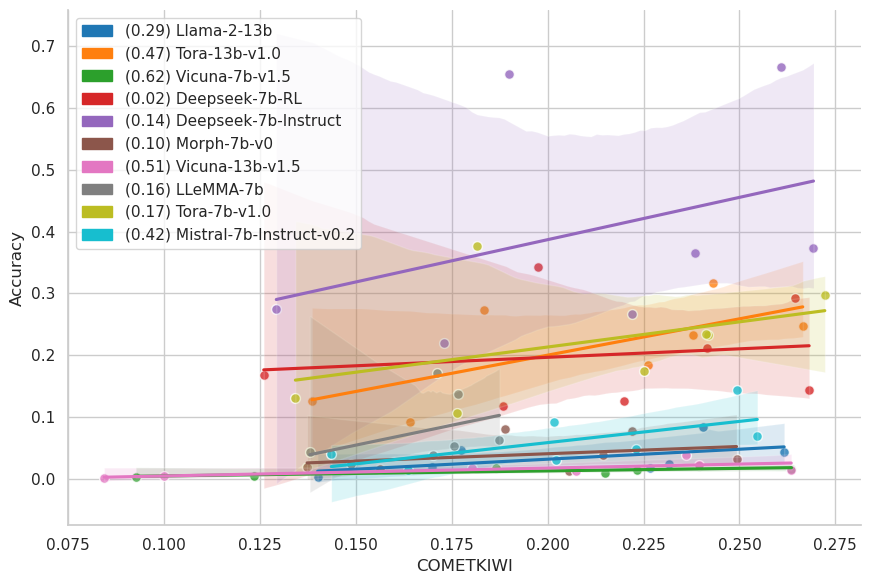

In [42]:
# put R2 next to model name in legend
# df['Log Accuracy'] = np.log(df['Accuracy'])
xcom_corr = df.groupby('model').apply(lambda x: x[['COMETKIWI', 'Accuracy']].corr().iloc[0, 1] ** 2)

g = sns.lmplot(
    data=df,
    x='COMETKIWI',
    y='Accuracy',
    hue='model',
    height=6,
    aspect=1.5,
    scatter_kws=dict(s=50, linewidths=1, edgecolor='w'),
    palette='tab10',
    # ci=None,
    # legend=False,  # turn off the original legend
)

import matplotlib.patches as mpatches

# Fetching the color palette based on the number of unique models
color_palette = sns.color_palette('tab10', n_colors=len(df['model'].unique()))

legend_patches = []
for i, model in enumerate([l.get_text() for l in g.legend.texts]):
    correlation = xcom_corr[model]
    legend_patches.append(mpatches.Patch(color=color_palette[i],
                                         label=f'({correlation:0.2f}) {model}'))

g.legend.set_visible(False)
plt.legend(handles=legend_patches)
plt.show()
# g.set(xscale="log", yscale="log")

In [38]:
??g.legend.set_visible

In [17]:
dir(g.legend)

['_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alignment',
 '_alpha',
 '_animated',
 '_auto_legend_data',
 '_axes',
 '_bbox_to_anchor',
 '_callbacks',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_custom_handler_map',
 '_default_handler_map',
 '_different_canvas',
 '_draggable',
 '_find_best_position',
 '_findoffset',
 '_fontsize',
 '_fully_clipped_to_axes',
 '_get_anchored_bbox',
 '_get_loc',
 '_gid',
 '_in_layout',
 '_init_legend_box',
 '_internal_update',
 '_label',
 '_legend_box',
 '_legend_handle_box',
 '_legend_title_box',
 '_loc',
 '_loc_real',
 '_loc_used_default',
 '_mode',
 '_mouseover',
 '_ncol

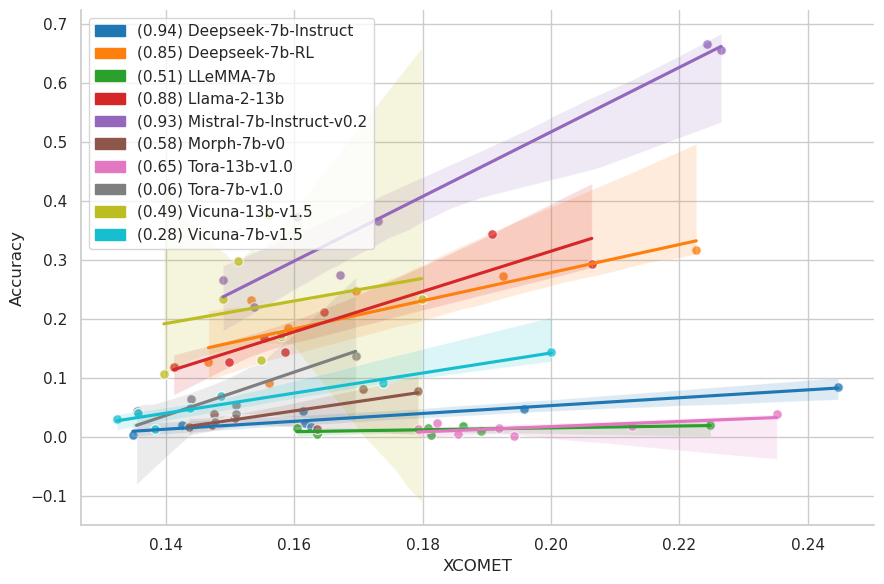

In [31]:
# put R2 next to model name in legend
# df['Log Accuracy'] = np.log(df['Accuracy'])
xcom_corr = df.groupby('model').apply(lambda x: x[['COMETKIWI', 'Accuracy']].corr().iloc[0, 1] ** 2)

g = sns.lmplot(
    data=df,
    x='COMETKIWI',
    y='Accuracy',
    hue='model',
    height=6,
    aspect=1.5,
    scatter_kws=dict(s=50, linewidths=1, edgecolor='w'),
    palette='tab10',
    legend=False,  # turn off the original legend
)

import matplotlib.patches as mpatches

# Fetching the color palette based on the number of unique models
color_palette = sns.color_palette('tab10', n_colors=len(df['model'].unique()))

legend_patches = []
for i, (model, correlation) in enumerate(zip(xcom_corr.index, xcom_corr)):
    legend_patches.append(mpatches.Patch(color=color_palette[i],
                                         label=f'({correlation:0.2f}) {model}'))

plt.legend(handles=legend_patches)
plt.show()
# g.set(xscale="log", yscale="log")

In [35]:
??corr_df.to_latex

In [36]:
# join correlation dataframes
corr_df = pd.concat([tfa_corr, tfce_corr], axis=1)
corr_df = corr_df.rename(columns={0: 'TFA', 1: 'TFCE'})
print(corr_df.to_latex())

\begin{tabular}{lrr}
\toprule
 & TFA & TFCE \\
model &  &  \\
\midrule
Deepseek-7b-Instruct & 0.439272 & 0.399167 \\
Deepseek-7b-RL & 0.285773 & 0.317733 \\
LLeMMA-7b & 0.100595 & 0.104666 \\
Mistral-7b-Instruct-v0.2 & 0.097707 & 0.131686 \\
Morph-7b-v0 & 0.060026 & 0.053734 \\
Tora-13b-v1.0 & 0.311476 & 0.389184 \\
Tora-7b-v1.0 & 0.376615 & 0.331863 \\
\bottomrule
\end{tabular}


In [70]:
??LinearRegression.score

In [93]:
# compute R^2
from sklearn.linear_model import LinearRegression

R2 = df.groupby('model').apply(
    lambda x: LinearRegression().fit(x[['Teacher Forced Accuracy']], x[['Accuracy']]).score(
        x[['Teacher Forced Accuracy']],
        x[['Accuracy']]))
R2

model
Deepseek-7b-Instruct    0.448161
Deepseek-7b-RL          0.364979
LLeMMA-7b               0.110630
Tora-13b-v1.0           0.490849
dtype: float64

In [58]:
# compute correlation between log accuracy and cross entropy
correlation = df.groupby('model').apply(lambda x: x[['Log Accuracy', 'Cross Entropy']].corr().iloc[0, 1])
correlation

model
EleutherAI_llemma_7b                     0.251294
deepseek-ai_deepseek-math-7b-instruct   -0.498419
deepseek-ai_deepseek-math-7b-rl         -0.221735
llm-agents_tora-13b-v1.0                -0.650091
dtype: float64

In [57]:
# compute correlation between grade and ppl
correlation = df.groupby('model').apply(lambda x: x[['grade', 'ppl']].corr().iloc[0, 1])
correlation

model
EleutherAI_llemma_7b                     0.165939
deepseek-ai_deepseek-math-7b-instruct   -0.471243
deepseek-ai_deepseek-math-7b-rl         -0.209154
llm-agents_tora-13b-v1.0                -0.646765
dtype: float64

In [59]:
# estimate the variance of the sample correlation
# using the Fisher transformation
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Testing_using_Statistical_Packages
n = df.groupby('model').apply(lambda x: x.shape[0])
variance = (1 - correlation ** 2) ** 2 / (n - 3)
variance

model
EleutherAI_llemma_7b                     0.219423
deepseek-ai_deepseek-math-7b-instruct    0.141217
deepseek-ai_deepseek-math-7b-rl          0.226021
llm-agents_tora-13b-v1.0                 0.083342
dtype: float64

In [92]:
# estimate it using the bootstrap
from sklearn.utils import resample
from scipy.stats import pearsonr


def bootstrap_correlation(df, model, n_bootstrap=1000):
    # get the data for the model
    model_data = df[df['model'] == model]
    # bootstrap
    bootstrap_correlations = []
    for _ in range(n_bootstrap):
        resampled_data = resample(model_data)
        correlation = pearsonr(resampled_data['Teacher Forced Accuracy'], resampled_data['Accuracy'])[0]
        bootstrap_correlations.append(correlation)
    return np.var(bootstrap_correlations)


bootstrap_variance = {model: bootstrap_correlation(df, model) for model in df['model'].unique()}
bootstrap_variance

{'Tora-13b-v1.0': 0.23448285248305342,
 'Deepseek-7b-RL': 0.041296458855237576,
 'Deepseek-7b-Instruct': 0.028462955520474013,
 'LLeMMA-7b': 0.1180691908994182}